# Data Extraction

In [53]:
# Normal imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Specific imports
import rtree
import pygeos
import geopandas
from geopandas import GeoDataFrame
from shapely import wkt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split


#Internal imports
from src.data_extraction.data_extraction import extract_initial_data
from src.constants import (
    NEW_COLUMNS_NAMES,
    REMOVE_COLUMNS_BY_INPUT,
    REMOVE_COLUMNS_BY_CORRELATIONS,
    NUM_VARIABLES_TO_SEE_DISTRIBUTION,
    BINARY_VARIABLES,
    IDEALISTA_COLORS
)
from src.preprocessing.preprocessing_utils import (
    generate_pandas_profiling_report,
    remove_duplicated_anuncios_id,
    find_single_value_columns,
    treatment_missing_values,
    visualize_distribution,
    visualize_binary_distribution,
    correlation_values,
    feature_engineering,
    detect_outliers,
    get_location_name_w_gdf,
    hist_plot_outliers
)

# Settings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Extract all dataset available, provided by idealista

In [54]:
df, df_ine, df_osm, df_pois, df_polygons = extract_initial_data(
    root_dir="input_data"
)

In [55]:
# Change columns names to friendly ones
df = df.drop(columns=["ADTYPOLOGY", "ADOPERATION"])
df.columns = NEW_COLUMNS_NAMES

Division train test

In [56]:
X = df.drop(columns=['precio']) 
y = df['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

## Polygons and INE censal polygons

#### Polygons

In [57]:
# Convert WKT strings to Shapely geometries and create a GeoDataFrame
df_polygons['geometry'] = df_polygons['WKT'].apply(wkt.loads)
gdf_polygons = geopandas.GeoDataFrame(df_polygons['geometry'], crs='epsg:4326')

# Add additional columns to the GeoDataFrame
gdf_polygons['barrio_id'] = df_polygons['LOCATIONID']
gdf_polygons['barrio'] = df_polygons['LOCATIONNAME']

# Create Point geometries using longitude and latitude coordinates from df_train
geometry = [Point(xy) for xy in zip(df_train.longitud, df.latitud)]

# Create a GeoDataFrame gdf_ads with df_prices data and geometry column
gdf_train_train = GeoDataFrame(df_train, crs="EPSG:4326", geometry=geometry)

# Apply a logarithmic scale transformation to the 'precio' column in gdf_ads
gdf_train_train['precio_logaritmico'] = np.log(gdf_train_train['precio'])


#### INE Censal Polygons

In [58]:
# Convert WKT strings to Shapely geometries and create a GeoDataFrame for census polygons
df_ine['geometry'] = df_ine['WKT'].apply(wkt.loads)
gdf_polygons_census = geopandas.GeoDataFrame(df_ine['geometry'], crs='epsg:4326')

# Add additional column 'CUSEC' to the GeoDataFrame representing census polygons
gdf_polygons_census['cusec'] = df_ine['CUSEC']

In [59]:
# Add the census codes (CUSEC)
gdf_train_train = geopandas.sjoin(gdf_train_train, gdf_polygons_census, how="inner")

# Drop index_right 
gdf_train_train = gdf_train_train.drop(columns=['index_right'])

# Now add the idealista zones (LOCATIONID, LOCATIONNAME)
gdf_train_train = geopandas.sjoin(gdf_train_train, gdf_polygons, how="inner")

# Drop index_right 
gdf_train_train = gdf_train_train.drop(columns=['index_right'])

df_train = gdf_train_train.copy()

## ASSETS - Basis

### General

In [61]:
# See general statistics of df
description_df = df_train.describe(percentiles=[0.995, 0.97]).transpose().style.format("{:.2f}")
description_df

,count,mean,std,min,50%,97%,99.5%,max
fecha,74599.00,201808.61,3.68,201803.00,201809.00,201812.00,201812.00,201812.00
precio_unitario_m2,74599.00,3670.99,1705.58,805.56,3491.23,7380.95,9112.51,9997.56
area_construida,74599.00,101.22,66.91,21.00,83.00,268.00,445.00,985.00
n_habitaciones,74599.00,2.58,1.26,0.00,3.00,5.00,7.00,93.00
n_banos,74599.00,1.58,0.84,0.00,1.00,4.00,5.00,20.00
terraza,74599.00,0.35,0.48,0.00,0.00,1.00,1.00,1.00
ascensor,74599.00,0.70,0.46,0.00,1.00,1.00,1.00,1.00
aire_acondicionado,74599.00,0.45,0.50,0.00,0.00,1.00,1.00,1.00
amueblado,74599.00,2.92,0.31,1.00,3.00,3.00,3.00,3.00
parking,74599.00,0.22,0.42,0.00,0.00,1.00,1.00,1.00


In [62]:
# Remove duplicated anuncios_id
df_train = remove_duplicated_anuncios_id(df_assets=df_train, criteria="last")

All duplicated id_anuncio values are associated with the same fecha.


In [63]:
# Remove columns by input
df_train = df_train.drop(columns=REMOVE_COLUMNS_BY_INPUT)
print('Removed columns:', REMOVE_COLUMNS_BY_INPUT)

Removed columns: ['fecha', 'id_anuncio']


In [64]:
# Remove columns that only have one different value
remove_unique_value_columns = find_single_value_columns(df=df_train)
df_train = df_train.drop(columns=remove_unique_value_columns)

Columns with only one distinct value: ['tipologia_imueble', 'operacion', 'ciudad']


In [65]:
df_train.shape

(62173, 44)

### Missing Values

In [66]:
# Missing values
df_train = treatment_missing_values(df=df_train)

Columns with missing values: Index(['ano_construccion', 'n_piso', 'exterior_interior', 'cat_calidad'], dtype='object')
ano_construccion: 59.92%
n_piso: 4.06%
exterior_interior: 6.76%
cat_calidad: 0.00%
Percentage of rows affected by dropping NaN values:", 0.09343284062213501


In [67]:
#Ano Construccion
antiguidade_ano_construccion=2018-df_train['ano_construccion']
print('Min antiguidade ano construccion', antiguidade_ano_construccion.min())
print('Max antiguidade ano construccion', antiguidade_ano_construccion.max())
antiguidade_cat_ano_construccion=2018-df_train['cat_ano_construccion']
print('Min antiguidade cat ano construccion', antiguidade_cat_ano_construccion.min())
print('Max antiguidade cat ano construccion', antiguidade_cat_ano_construccion.max())

Min antiguidade ano construccion -273.0
Max antiguidade ano construccion 2017.0
Min antiguidade cat ano construccion 0
Max antiguidade cat ano construccion 391


### Data Treatment and Feature Engineering

In [68]:
# Mean price by barrio
df_metrics_barrios= df_train.groupby(['barrio']).agg({'precio':['median', 'mean', 'std'], 
                                   'precio_unitario_m2':['median', 'mean', 'std']}).reset_index()

df_metrics_barrios.columns = ['barrio', 
                         'precio_median_barrio', 'precio_mean_barrio', 'precio_std_barrio', 
                         'precio_unitario_m2_median_barrio', 'precio_unitario_m2_mean_barrio', 'precio_unitario_m2_std_barrio']

In [69]:
# Add mean price by barrio to dataset
df_train=df_train.merge(df_metrics_barrios[['barrio', 'precio_mean_barrio', 'precio_unitario_m2_mean_barrio']], on=['barrio'], how="inner")

In [70]:
# Feature Engineering: add new variables
(
    add_columns,
    remove_columns_by_creating_new_variables,
    df_train,
) = feature_engineering(df=df_train)

print("Columns added:", add_columns)
print('Columns removed by adding new:', remove_columns_by_creating_new_variables)

Columns added: ['interior', 'antiguidade']
Columns removed by adding new: ['cat_ano_construccion', 'ano_construccion', 'exterior_interior', 'a_reformar']


Correlations

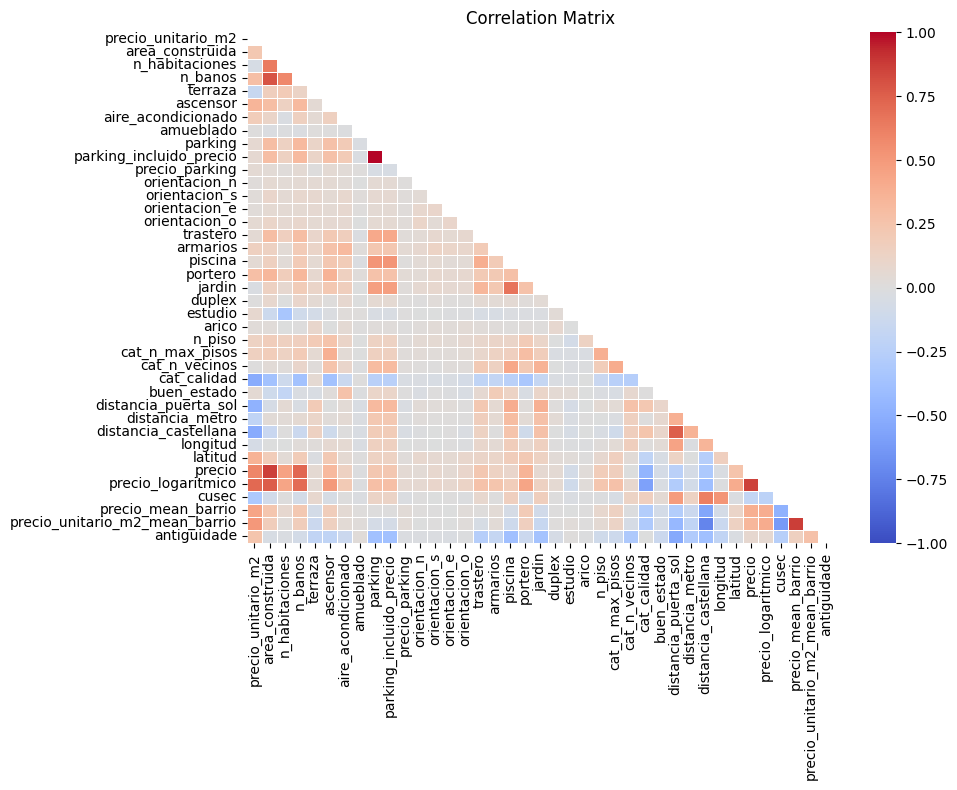

Correlated variables: area_construida, precio, Correlation: 0.8615258823607348
Correlated variables: parking, parking_incluido_precio, Correlation: 1.0
Correlated variables: precio, precio_logaritmico, Correlation: 0.8569381887270995
Correlated variables: precio_mean_barrio, precio_unitario_m2_mean_barrio, Correlation: 0.8731931214481296
After evaluate which columns remove by coorelations, update list in constants REMOVE_COLUMNS_BY_CORRELATIONS


In [71]:
# Correlation values
correlation_matrix, correlated_variables = correlation_values(df=df_train, threshold=0.8)
# Remove columns by high correlations
df_train = df_train.drop(columns=REMOVE_COLUMNS_BY_CORRELATIONS)

Outliers

{'n_banos': 5.0, 'n_habitaciones': 7.0, 'area_construida': 440.0, 'distancia_castellana': 9.284179330307158}


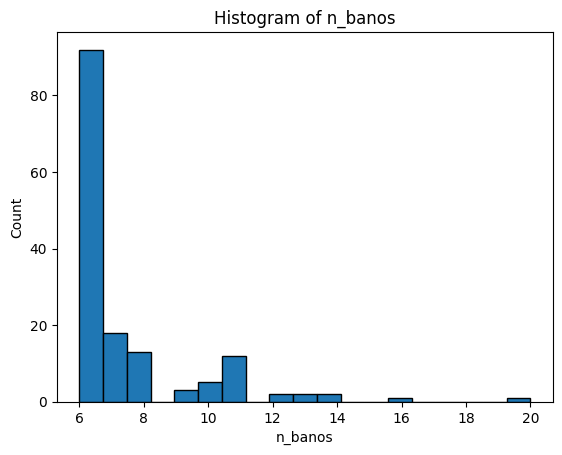

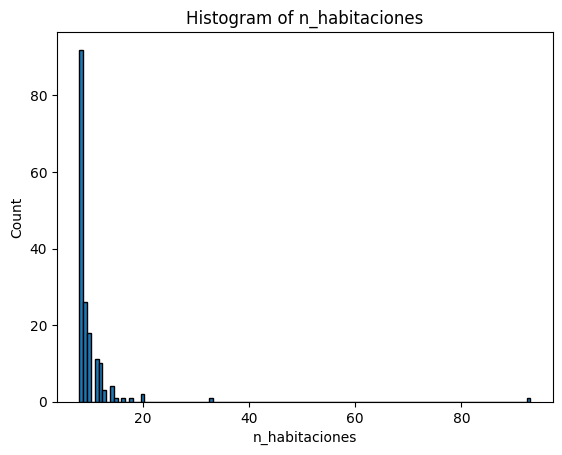

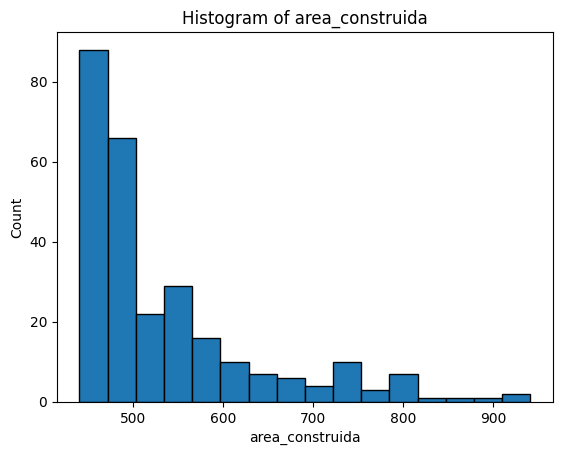

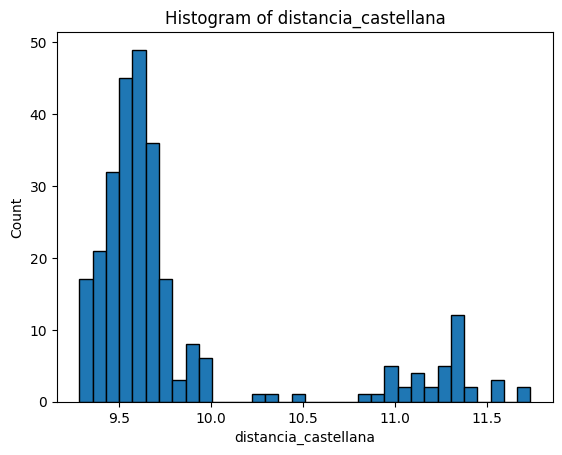

Percentage of rows deleted:  0.013195681413355587


In [72]:
nr_row_before=df_train.shape[0]

variables_most_correlated_w_target=['n_banos','n_habitaciones', 'area_construida', 'distancia_castellana']

percentile_995_values = {}

for var in variables_most_correlated_w_target:
    percentile_995_values[var] = df_train[var].quantile(0.995)

print(percentile_995_values)

for var in variables_most_correlated_w_target:
    hist_plot_outliers(df=df_train[df_train[var] > percentile_995_values[var]],name_variable = var)

condition_to_exclude_outliers = ((df_train['n_banos']>percentile_995_values['n_banos']) 
                                 | (df_train['n_habitaciones']>percentile_995_values['n_habitaciones']) 
                                 | (df_train['area_construida']>percentile_995_values['area_construida']) 
                                 | (df_train['distancia_castellana']>percentile_995_values['distancia_castellana']))

df_train=df_train[~condition_to_exclude_outliers]

nr_row_after=df_train.shape[0]

print('Percentage of rows deleted: ', 1-nr_row_after/nr_row_before)
    

In [73]:
#FIXME
# Analyse target outliers: inter quartis
outliers = detect_outliers(df=df_train, column_name='precio', threshold=10)
outliers.shape

(13, 42)

N_Banos: Impute values when n_banos = 0

In [74]:
# Filter rows where n_banos > 0
filtered_df = df_train[df_train['n_banos'] > 0]

# Calculate number of bathrooms per square meter
filtered_df['n_banos_m2'] = filtered_df['n_banos'] / filtered_df['area_construida']

# Calculate mean number of bathrooms per square meter
mean_bathrooms_per_sqm = filtered_df['n_banos_m2'].median()

# Impute number of bathrooms for rows where n_banos == 0: mean number of bath by m^2 * m^2, rounded, and minimum 1
df_train['n_banos_m2'] = (np.maximum(mean_bathrooms_per_sqm * df_train['area_construida'],1)).round().astype(int)

# Validate if it is a good way to values, calculating mape comparing with the real n_banos
df_train_aux = df_train[df_train['n_banos']>0]
absolute_percentage_errors = np.abs((df_train_aux['n_banos'] - df_train_aux['n_banos_m2']) / df_train_aux['n_banos'])
mape = np.mean(absolute_percentage_errors) * 100
print("MAPE", mape)

# Delete filtered_df, df_train_aux as they are only auxiliar 
del filtered_df, df_train_aux

# # Assign the imputed value to n_banos where n_banos == 0. All houses with 0 bathrooms are houses to renovate
df_train.loc[df_train['n_banos'] == 0, 'n_banos'] = df_train.loc[df_train['n_banos'] == 0, 'n_banos_m2']

# # # Drop the n_banos_m2 column as it is no longer needed
df_train = df_train.drop(columns=['n_banos_m2'])

MAPE 14.861292839196752


# Exportar df_train_util

In [76]:
df_train.to_csv(r'C:\Users\aimartins\OneDrive - Parfois, SA\Desktop\MDS6\MDS6-IDEALISTA\output_data\df_train_util.csv', index=False)